# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

# Problem Statement

The US Geological Survey publishes a [list of Strategic Minerals](https://www.usgs.gov/news/national-news-release/us-geological-survey-releases-2022-list-critical-minerals). Having a secure supply of these minerals is essential to our security and economic prosperity. However many of these minerals are sourced from outside of the US. This assignment is to develop a reference catalog of the source or sources of each of these minerals and a judgement on the reliability of each source under stressed circumstance (e.g. war, economic crisis, etc.)

Notes:

* You will need to identify a source or sources for each of the minerals in the 2022 List of Critical Minerals

* You will need to categorize each source country as an ally, a competitor or a neutral party.

* You will need to develop data visualizations that tell the story of source dependency and shortfall impact.


# Data Import/Cleaning

All minerals production data was sourced from [USGS public datasets](https://www.sciencebase.gov/catalog/item/6197ccbed34eb622f692ee1c). Multiple files were aggregated together (one for each mineral) to generate a usable dataframe.

In [2]:
directory = 'world/'

df = pd.DataFrame(columns=['source', 'country', 'type', 'prod_2020', 'est_prod_2021','mineral', 'unit'])
file_list = os.listdir(directory)
file_list = [filename[:-4].replace('_world', '').replace('_meta', '') for filename in file_list]

for file in file_list:
    
    # get xml and csv file names
    filename = str(os.fsdecode(file))
    csv_file_name = f'{file}_world.csv'
    xml_file_name = f'{file}_meta.xml'

    # parse xml file to get mineral name
    with open(f'{directory}{xml_file_name}', 'r') as f:
        metadata = f.read()
    
    soup = BeautifulSoup(metadata, "xml")
    mineral = str(soup.find_all('title')[0]).replace('Mineral Commodity Summaries 2022 -', '')
    mineral = mineral.replace('Data Release', '')
    mineral = mineral.replace('<title>', '')
    mineral = mineral.replace('</title>', '')
    mineral = mineral.strip()
        
    # parse csv files to get mineral production data
    tmp = pd.read_csv(f'{directory}{csv_file_name}')
    tmp = tmp.iloc[:,:5]
    tmp = tmp[tmp["Country"].str.contains("World")==False]
    tmp['Country'] = tmp['Country'].str.replace(r"\(.*\)","", regex=True)
    tmp['Country'] = tmp['Country'].str.replace('\d+', '', regex=True)

    tmp['Country'] = tmp['Country'].str.strip()
    
    
    if str(tmp[tmp.columns[-1]].dtype) == 'object':
        tmp[tmp.columns[-1]] = tmp.iloc[:,-1].str.replace(',', '')
        tmp[tmp.columns[-1]] = tmp[tmp.columns[-1]].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    if str(tmp[tmp.columns[-2]].dtype) == 'object':
        tmp[tmp.columns[-2]] = tmp.iloc[:,-2].str.replace(',', '')
        tmp[tmp.columns[-2]] = tmp[tmp.columns[-2]].apply(lambda x: pd.to_numeric(x, errors='coerce') )

    unit = tmp.columns[-1].split('_')[1] 
    tmp.columns = ['source', 'country', 'type', 'prod_2020', 'est_prod_2021']
    tmp['unit'] = unit
    tmp['mineral'] = mineral
    df = pd.concat([df, tmp])

In [3]:
df['prod_2020'] = df['prod_2020'].astype(float)
df['est_prod_2021'] = df['est_prod_2021'].astype(float)
df.head()

,source,country,type,prod_2020,est_prod_2021,mineral,unit
0,MCS2022,United States,Sponge Metal Production and Sponge and Pigment...,NaN,NaN,TITANIUM AND TITANIUM DIOXIDE,Sponge
1,MCS2022,Australia,Sponge Metal Production and Sponge and Pigment...,0.0,0.0,TITANIUM AND TITANIUM DIOXIDE,Sponge
2,MCS2022,Canada,Sponge Metal Production and Sponge and Pigment...,0.0,0.0,TITANIUM AND TITANIUM DIOXIDE,Sponge
3,MCS2022,China,Sponge Metal Production and Sponge and Pigment...,123000.0,120000.0,TITANIUM AND TITANIUM DIOXIDE,Sponge
4,MCS2022,Germany,Sponge Metal Production and Sponge and Pigment...,0.0,0.0,TITANIUM AND TITANIUM DIOXIDE,Sponge


US ally/competitor data generated from personal research and knowledge of US global affairs. This data is joined to the previously created mineral production dataframe. 

In [4]:
us_relations = pd.read_csv('us_relations.csv')
df = pd.merge(df, us_relations, how='left', on='country')
df['relationship'] = df['relationship'].fillna('neutral')
df = df.drop_duplicates()
df.head()

,source,country,type,prod_2020,est_prod_2021,mineral,unit,relationship
0,MCS2022,United States,Sponge Metal Production and Sponge and Pigment...,NaN,NaN,TITANIUM AND TITANIUM DIOXIDE,Sponge,self
2,MCS2022,Australia,Sponge Metal Production and Sponge and Pigment...,0.0,0.0,TITANIUM AND TITANIUM DIOXIDE,Sponge,ally
3,MCS2022,Canada,Sponge Metal Production and Sponge and Pigment...,0.0,0.0,TITANIUM AND TITANIUM DIOXIDE,Sponge,ally
4,MCS2022,China,Sponge Metal Production and Sponge and Pigment...,123000.0,120000.0,TITANIUM AND TITANIUM DIOXIDE,Sponge,competitor
5,MCS2022,Germany,Sponge Metal Production and Sponge and Pigment...,0.0,0.0,TITANIUM AND TITANIUM DIOXIDE,Sponge,ally


# Create Figures

In [5]:
combined = df.groupby(by=['mineral','relationship']).sum(numeric_only=True).reset_index()
totals = df.groupby(by='mineral').sum(numeric_only=True).reset_index()
combined = pd.merge(combined, totals, on='mineral', how='left', suffixes=('', '_total'))
combined['coverage_2020'] = combined['prod_2020'] / combined['prod_2020_total']
combined['coverage_2021'] = combined['est_prod_2021'] / combined['est_prod_2021_total']
combined.head()

,mineral,relationship,prod_2020,est_prod_2021,prod_2020_total,est_prod_2021_total,coverage_2020,coverage_2021
0,ALUMINUM,ally,14200.0,14290.0,141182.0,144620.0,0.100579,0.098811
1,ALUMINUM,competitor,87060.0,89720.0,141182.0,144620.0,0.616651,0.620384
2,ALUMINUM,neutral,37120.0,38090.0,141182.0,144620.0,0.262923,0.263380
3,ALUMINUM,self,2802.0,2520.0,141182.0,144620.0,0.019847,0.017425
4,ANTIMONY,ally,5932.0,5402.0,110719.0,109102.0,0.053577,0.049513


In [6]:
minerals = pd.DataFrame(list((set(combined.mineral.values))), columns=['mineral'])
custom_sort = combined[combined['relationship'].isin(['self', 'ally'])]
custom_sort = custom_sort.groupby(by='mineral').sum(numeric_only=True).reset_index()
custom_sort = pd.merge(minerals, custom_sort, how='left').fillna(0)
custom_sort = custom_sort.sort_values(by='coverage_2021')['mineral'].values
len(custom_sort)

74

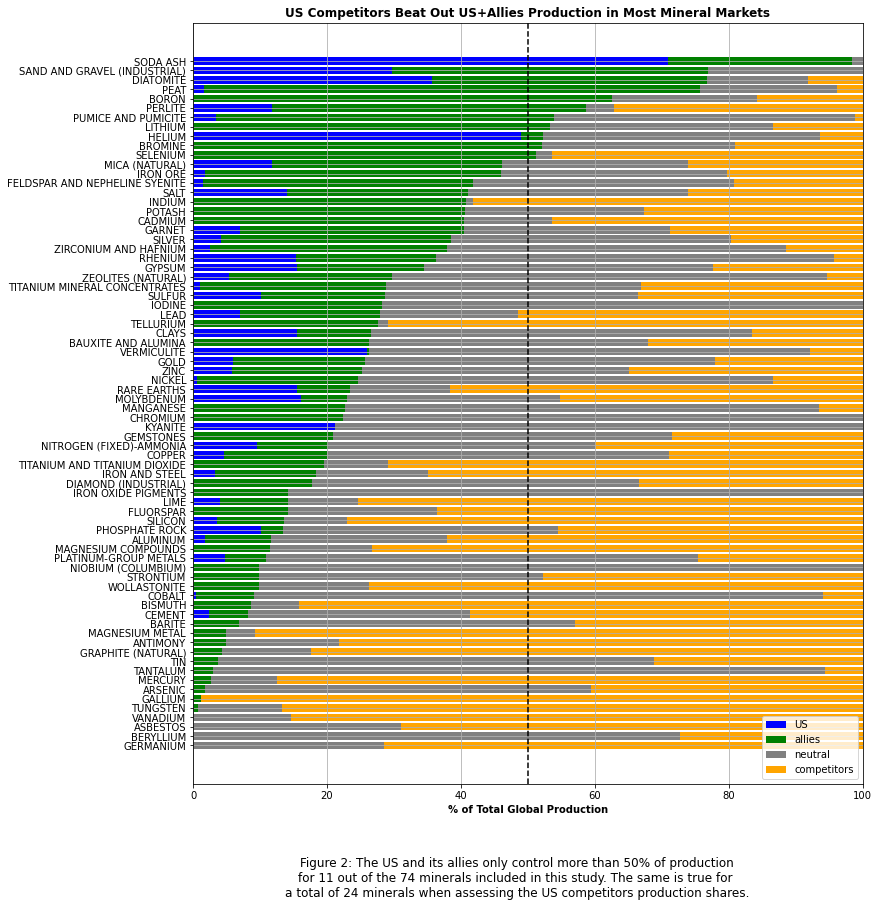

In [7]:
plt.figure(figsize=(12,14))
rels = ['self', 'ally', 'neutral', 'competitor']
minerals = pd.DataFrame(list((set(combined.mineral.values))), columns=['mineral'])
bottoms = np.zeros(len(set(combined.mineral.values)))
colors = ['blue', 'green', 'gray', 'orange']
labels = ['US', 'allies', 'neutral', 'competitors']

for i, rel in enumerate(rels):
    tmp = combined[combined['relationship'] == rel]
    tmp = pd.merge(minerals, tmp, how='left').fillna(0)
    tmp = tmp.set_index('mineral')
    tmp = tmp.loc[custom_sort].reset_index()
    plt.barh(tmp.mineral, tmp.coverage_2021 * 100, left=bottoms, color=colors[i], label=labels[i])
    bottoms = np.add(bottoms, tmp.coverage_2021 * 100)

plt.axvline(50, color='black', ls='--')
plt.title('US Competitors Beat Out US+Allies Production in Most Mineral Markets', fontweight='bold')
plt.xlabel('% of Total Global Production', fontweight='bold')
plt.grid()
plt.legend()

caption = '''
Figure 2: The US and its allies only control more than 50% of production
for 11 out of the 74 minerals included in this study. The same is true for 
a total of 24 minerals when assessing the US competitors production shares.
'''
plt.figtext(0.5, -0.00001, caption, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

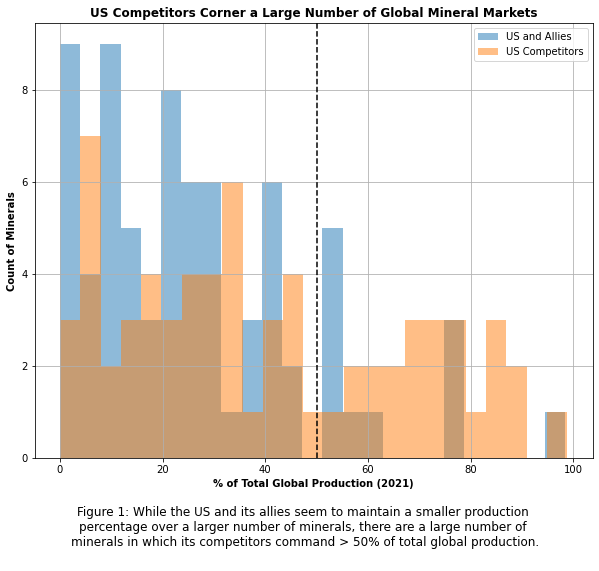

In [8]:
plt.figure(figsize=(10,8))

us_ally = combined[combined['relationship'].isin(['ally', 'self'])].groupby(by='mineral').sum().reset_index()
competitor = combined[combined['relationship'] == 'competitor']

plt.hist(us_ally.coverage_2021 * 100, bins=25, alpha=0.5, label='US and Allies')
plt.hist(competitor.coverage_2021 * 100, bins=25, alpha=0.5, label='US Competitors')
plt.title('US Competitors Corner a Large Number of Global Mineral Markets', fontweight='bold')
plt.ylabel('Count of Minerals', fontweight='bold')
plt.xlabel('% of Total Global Production (2021)', fontweight='bold')
plt.axvline(50, color='black', ls='--')
plt.grid()
plt.legend()

caption = '''
Figure 1: While the US and its allies seem to maintain a smaller production 
percentage over a larger number of minerals, there are a large number of 
minerals in which its competitors command > 50% of total global production.
'''
plt.figtext(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()
plt.show()

In [9]:
main_comps = df[df['country'].isin(['Russia', 'United States', 'China'])]
main_comps = pd.merge(main_comps, totals, on='mineral', how='left', suffixes=('', '_total'))
main_comps = main_comps.fillna(0)
main_comps['coverage_2021'] = main_comps['est_prod_2021'] / main_comps['est_prod_2021_total']
main_comps

,source,country,type,prod_2020,est_prod_2021,mineral,unit,relationship,prod_2020_total,est_prod_2021_total,coverage_2021
0,MCS2022,United States,Sponge Metal Production and Sponge and Pigment...,0.0,0.0,TITANIUM AND TITANIUM DIOXIDE,Sponge,self,226250.0,207350.0,0.000000
1,MCS2022,China,Sponge Metal Production and Sponge and Pigment...,123000.0,120000.0,TITANIUM AND TITANIUM DIOXIDE,Sponge,competitor,226250.0,207350.0,0.578732
2,MCS2022,Russia,Sponge Metal Production and Sponge and Pigment...,31000.0,27000.0,TITANIUM AND TITANIUM DIOXIDE,Sponge,competitor,226250.0,207350.0,0.130215
3,MCS2022,United States,"Production, all forms, thousand metric tons co...",7890.0,8100.0,SULFUR,kt,self,79742.0,79650.0,0.101695
4,MCS2022,China,"Production, all forms, thousand metric tons co...",17300.0,17000.0,SULFUR,kt,competitor,79742.0,79650.0,0.213434
...,...,...,...,...,...,...,...,...,...,...,...
201,MCS2022,China,Smelter production,886.0,800.0,MAGNESIUM METAL,kt,competitor,1005.0,947.0,0.844773
202,MCS2022,Russia,Smelter production,48.0,60.0,MAGNESIUM METAL,kt,competitor,1005.0,947.0,0.063358
203,MCS2022,United States,Mine production,430.0,400.0,FELDSPAR AND NEPHELINE SYENITE,kt,self,24439.0,27940.0,0.014316
204,MCS2022,China,Mine production,2500.0,2600.0,FELDSPAR AND NEPHELINE SYENITE,kt,competitor,24439.0,27940.0,0.093057


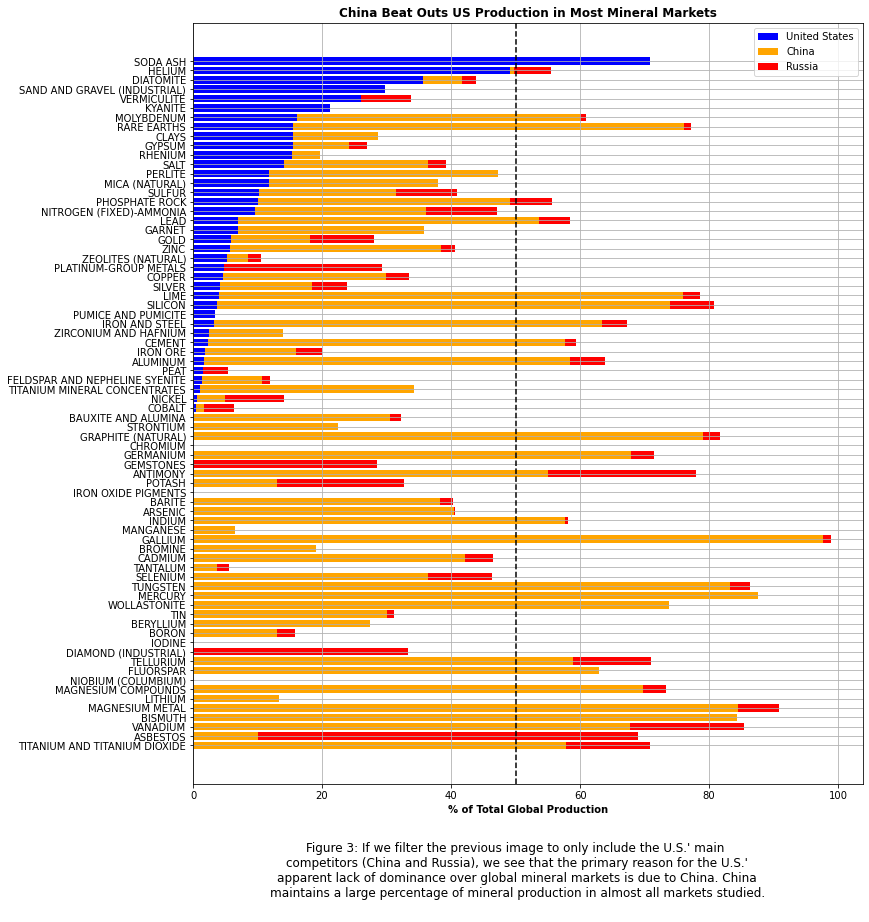

In [10]:
plt.figure(figsize=(12,14))
rels = ['United States', 'China', 'Russia']
bottoms = np.zeros(len(set(combined.mineral.values)))
colors = ['blue', 'orange', 'red']

custom_sort = main_comps[main_comps['country'] == 'United States']
custom_sort = custom_sort.groupby(by='mineral').sum(numeric_only=True).reset_index()
custom_sort = pd.merge(minerals, custom_sort, how='left').fillna(0)
custom_sort = custom_sort.sort_values(by='coverage_2021')['mineral'].values


for i, rel in enumerate(rels):
    tmp = main_comps[main_comps['country'] == rel]
    tmp = tmp.groupby(by='mineral').sum().reset_index()
    tmp = pd.merge(minerals, tmp, how='left').fillna(0)
    tmp = tmp.set_index('mineral')
    tmp = tmp.loc[custom_sort].reset_index()
    plt.barh(tmp.mineral, tmp.coverage_2021 * 100, left=bottoms, color=colors[i], label=rel)
    bottoms = np.add(bottoms, tmp.coverage_2021 * 100)

plt.axvline(50, color='black', ls='--')
plt.title('China Beat Outs US Production in Most Mineral Markets', fontweight='bold')
plt.xlabel('% of Total Global Production', fontweight='bold')
plt.grid()
plt.legend()

caption = '''
Figure 3: If we filter the previous image to only include the U.S.' main 
competitors (China and Russia), we see that the primary reason for the U.S.'
apparent lack of dominance over global mineral markets is due to China. China
maintains a large percentage of mineral production in almost all markets studied.
'''
plt.figtext(0.5, -0.00001, caption, wrap=True, horizontalalignment='center', fontsize=12)


plt.show()